## Gets River Forecast Data (5- and 28- Day)

In [2]:
def get_ms_fcst(file_out5,file_out28,today_date):
    import requests as req
    import urllib.request as urlreq
    import time
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt

    # NWS Observations and Forecasts for the Lower Mississippi/Ohio site
    nws = req.get('https://www.weather.gov/lmrfc/obsfcst_mississippi')

    # Parse html data from website
    nws_html = BeautifulSoup(nws.text, "html.parser") # NOTE: data is pre-formatted <pre>

    ###################### Get 5-day forecast data ##########################
    dum = nws_html.findAll('a')[118]
    pred_5day = dum['href']
    html_5day = BeautifulSoup(req.get(pred_5day).text, "html.parser")
    text_5day = html_5day.find('pre').contents[0]

    # Separate the rows specified in the data by \n
    split_5day = text_5day.string.split('\n') # rows are separated by \n
    # Separate items in row (space)
    list_5day = [[]] * np.size(split_5day)
    for i in range(np.size(split_5day)):
        list_5day[i] = split_5day[i].split() # separate each entry within the row

    # Combine city names into one cell if multiple words (e.g., Baton Rouge, New Orleans)
    for i in range(np.size(list_5day)):
        try:
            list_5day[i][0]
            if list_5day[i][0] == '':
                next
            elif list_5day[i][1] == '':
                next
            elif list_5day[i][0] == 'STATION':
                next    
            elif list_5day[i][0] == 'STG':
                list_5day[i].insert(0,'')
                list_5day[i].insert(1,'')
            elif list_5day[i][1].isnumeric():
                list_5day[i][1] = list_5day[i][1]
            elif list_5day[i][1].isalpha():
                list_5day[i][0] = list_5day[i][0] + ' ' + list_5day[i][1]
                del list_5day[i][1]
        except:
            continue


    # Combine city names into one cell if more than two words (e.g., Red River Landing)
    for i in range(np.size(list_5day)):
        try:
            list_5day[i][0]
            if list_5day[i][0] == '':
                next
            elif list_5day[i][1] == '':
                next
            elif list_5day[i][0] == 'STATION':
                next
            elif list_5day[i][1] == 'TDA':
                next
            elif list_5day[i][1].isnumeric():
                list_5day[i][1] = fcst_5day[i][1]
            elif list_5day[i][1].isalpha():
                list_5day[i][0] = list_5day[i][0] + ' ' + list_5day[i][1]
                del list_5day[i][1]
        except:
            continue

    # Put list into dataframe
    fcst_5day = pd.DataFrame(list_5day)



    # Pause so website doesn't think we're a hacker (probably more relevant for loops)
    time.sleep(1)

    ##################### Get 28-day forecast data ############################
    dum = nws_html.findAll('a')[119]
    pred_28day = dum['href']
    html_28day = BeautifulSoup(req.get(pred_28day).text, "html.parser")
    text_28day = html_28day.findAll('pre')[0]
    # Separate the rows specified in the data by \n
    split_28day = text_28day.string.split('\n') # rows are separated by \n
    list_28day = [[]] * np.size(split_28day)
    for i in range(np.size(split_28day)):
        list_28day[i]=split_28day[i].split() # separate each entry within the row


    # Put list into data frame
    fcst_28day = pd.DataFrame(list_28day)

    ############################# Save CSV output ########################

    # Save 5-day forecast file 
    import ntpath
    path_out5 = ntpath.dirname(file_out5)
    
    try: # Create year directory if not done so (really should only be an issue once per year)
        os.mkdir(ntpath.split(path_out5)[0])
    except:
        pass
    
    try:
        os.mkdir(path_out5) # create path for today (if not previously created)
        pd.DataFrame.to_csv(fcst_5day, path_out5 + "\\" +  "test_FORECAST_" + today_date + ".csv")
    except:
        pd.DataFrame.to_csv(fcst_5day, path_out5 + "\\" + "test_FORECAST_" + today_date + ".csv")

    # Save 28-day forecast file 
    path_out28 = ntpath.dirname(file_out28)
    try: # Create year directory if not done so (really should only be an issue once per year)
        os.mkdir(ntpath.split(path_out28)[0])
    except:
        pass
    try:
        os.mkdir(path_out28) # create path for today (if not previously created)
        pd.DataFrame.to_csv(fcst_28day, path_out28 + "\\" + "test_24hr change NWS_" + today_date + ".csv", date_format='%mm-%dd-%YY')
    except:
        pd.DataFrame.to_csv(fcst_28day, path_out28 + "\\" + "test_24hr change NWS_" + today_date + ".csv", date_format='%mm-%dd-%YY')
        
    ############################### Plot Stages for New Orleans ##########################
    fcst28 = np.array(fcst_28day)
    k, l = np.where(fcst28=="NORL1") # used k and l as indices since i,j had been used

    dates_fcst21_NO = [datetime.strptime(x, "%m-%d-%y").date() for x in fcst28[int(k)+1:int(k)+22,0]]

    ######## Plot river stage forecast for 21 days
    plt.figure(figsize=[8,4])
    fcst_28_NO = np.float64(fcst28[int(k)+1:int(k)+21+1,int(l)])
    plt.plot_date(dates_fcst21_NO,fcst_28_NO,fmt='--', color='purple',xdate=True,ydate=False)
    
    # Add condtionals for the y-limits to adjust for scaling (depends on river max height)
    if np.max(fcst_28_NO) >= 14:
        plt.ylim((10, 20))
        plt.hlines(11, dates_fcst21_NO[0],dates_fcst21_NO[-1], colors = 'r') # Stage 1 Flood Marker
        plt.hlines(15, dates_fcst21_NO[0],dates_fcst21_NO[-1], colors = 'g') # Stage 2 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1','Phase 2'],loc="lower left")
    elif np.max(fcst_28_NO) >= 10 and np.max(fcst_28_NO) < 14:
        plt.ylim((6, 16))
        plt.hlines(11, dates_fcst21_NO[0],dates_fcst21_NO[-1], colors = 'r') # Stage 1 Flood Marker
        plt.hlines(15, dates_fcst21_NO[0],dates_fcst21_NO[-1], colors = 'g') # Stage 2 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1','Phase 2'],loc="lower left")
    elif np.max(fcst_28_NO) < 10:
        plt.ylim((2, 12))
        plt.hlines(11, dates_fcst21_NO[0],dates_fcst21_NO[-1], colors = 'r') # Stage 1 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1'],loc="lower left")
        
    plt.xlim((dates_fcst21_NO[0],dates_fcst21_NO[-1]))
    plt.gca().set
    plt.grid(True)
    plt.xticks(dates_fcst21_NO )
    plt.xticks(dates_fcst21_NO[0:21:5],dates_fcst21_NO[0:21:5] )
    plt.title("Mississippi River at New Orleans")
    plt.xlabel("River Stage (FT)")
    plt.tight_layout()
    plt.savefig(path_out28 + "\\" + "test_24hr_change_NWS_NewOrleans_" + today_date  + ".png")
    
    del k, l
    ############################### Plot Stages for Red River Landing ##########################
    fcst28 = np.array(fcst_28day)
    k, l = np.where(fcst28=="RRLL1") # used k and l as indices since i,j had been used

    dates_fcst21_RR = [datetime.strptime(x, "%m-%d-%y").date() for x in fcst28[int(k)+1:int(k)+22,0]]

    ######## Plot river stage forecast for 21 days
    plt.figure(figsize=[8,4])
    fcst_28_RR = np.float64(fcst28[int(k)+1:int(k)+21+1,int(l)])
    plt.plot_date(dates_fcst21_RR,fcst_28_RR,fmt='--', color='purple',xdate=True,ydate=False)
    # Add condtionals for the y-limits to adjust for scaling
    if np.max(fcst_28_RR) >= 55:
        plt.ylim((45, 65))
        plt.hlines(48, dates_fcst21_RR[0],dates_fcst21_RR[-1], colors = 'r') # Stage 1 Flood Marker
        plt.hlines(56, dates_fcst21_RR[0],dates_fcst21_RR[-1], colors = 'g') # Stage 1 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1','Phase 2'],loc="lower left")
    elif np.max(fcst_28_RR) >= 45 and np.max(fcst_28_RR) < 55:
        plt.ylim((40, 60))
        plt.hlines(48, dates_fcst21_RR[0],dates_fcst21_RR[-1], colors = 'r') # Stage 1 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1'],loc="lower left")
    elif np.max(fcst_28_RR) >= 35 and np.max(fcst_28_RR) < 45:
        plt.ylim((30, 50))
        plt.hlines(48, dates_fcst21_RR[0],dates_fcst21_RR[-1], colors = 'r') # Stage 1 Flood Marker
        plt.legend(['NWS Stage, FT','Phase 1'],loc="lower left")
    elif np.max(fcst_28_RR) >= 25 and np.max(fcst_28_RR) < 35:
        plt.ylim((20, 40))
        plt.legend(['NWS Stage, FT'],loc="lower left")
    elif np.max(fcst_28_RR) >= 15 and np.max(fcst_28_RR) < 25:
        plt.ylim((10, 30))
        plt.legend(['NWS Stage, FT'],loc="lower left")        
    elif np.max(fcst_28_RR) < 15:
        plt.ylim((0, 20))
        plt.legend(['NWS Stage, FT'],loc="lower left") 
        
    plt.xlim((dates_fcst21_RR[0],dates_fcst21_RR[-1]))
    plt.gca().set
    plt.grid(True)
    plt.xticks(dates_fcst21_RR )
    plt.xticks(dates_fcst21_RR[0:21:5],dates_fcst21_RR[0:21:5] )
    plt.title("Mississippi River at Red River Landing")
    plt.xlabel("River Stage (FT)")
    plt.tight_layout()
    plt.savefig(path_out28 + "\\" + "test_24hr_change_NWS_RedRiverLanding_" + today_date  + ".png")

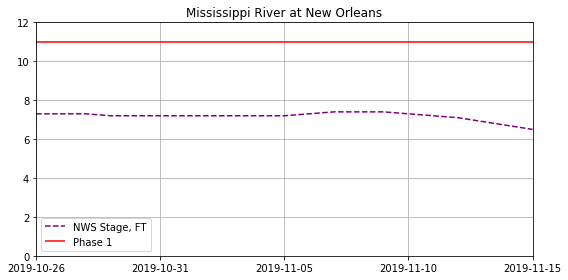